## This example creates weights .csv file. Weights are assigned semi-automatically. The weight of sodium current transient is increased, while the weight of pipette charging transient is decreased.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import sys
import json
import os

from scipy.signal import find_peaks

In [2]:
trace_filename = '../data/traces/activation.csv'
protocol_filename = '../data/protocols/activation.csv'

In [3]:
trace = pd.read_csv(trace_filename)
protocol = pd.read_csv(protocol_filename)

## Plot experimental trace.

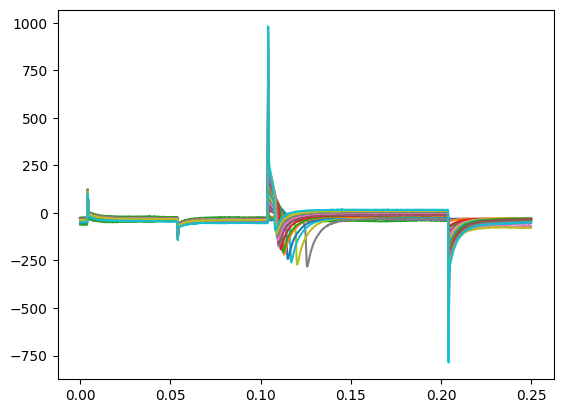

In [4]:
plt.plot(trace['t'], trace.drop('t', axis=1))
None

In [5]:
diffs = protocol.drop('t', axis = 1)[protocol.columns[-5]].diff(periods = 1).drop_duplicates()[2:]
times = protocol.t[diffs.index]

print("Command voltage changed at:")
pd.DataFrame(times.values, columns=['t'])

Command voltage changed at:


,t
0,0.00395
1,0.05400
2,0.10395
3,0.20400


## Input the voltage step starting time, approximate current transient end time, approximate pipette charging time and desired weight values below. 
The weight is equal to:

    pipette weight -- from t_start to t_start+pipette time. 
    peak weight    -- from from the start till the end of the current transient.
    1              -- after the end of current trace or t_end
    1              -- everywhere else
The heuristic algorithm to determine the current transient:    
1. The current is supposed to be negative (depolarizing).
2. Find the baseline current at t_end. t_end is determined by user manually below.
3. The current transient start is determined as the time when trace crosses the baseline for the first time (i.e. becomes negative).
4. peaks are determined as the moments of the maximum current. Latest t_peak among the voltage steps is saved (i.e when the activation was the slowest). 
5. Current transient end is the minimum of the following: 
 * The last moment when the negative current (below the baseline) was observed. 
 * t_start+2*(t_peak-t_start).

In [6]:
t_start = 0.10395    # start time of the voltage step, in seconds
t_end = 0.15         # the approximate end of current transient, in seconds. Used to determine the baseline.
pipette_time = 0.001 # the approximate pipette charging time, in seconds

pipette_weight = 0.01 # weight for pipette charging transient (should be <1.)
peak_weight = 100     # weight for current transient (should be >1.)

In [7]:
dt = protocol.t[1]-protocol.t[0]
pipette_len = int(pipette_time/dt)

In [8]:
start = np.where(trace.t>=t_start)[0][0]+pipette_len
end = np.where(trace.t<=t_end)[0][-1]
len_baseline = int((end - start)/20)

In [9]:
# find peaks
data = trace.drop('t', axis=1)[start:end]
baselines = data[-len_baseline:].mean()
min_height = -(data - baselines).min().min()/5

peaks = {}
for sweep in data:
    peak = find_peaks(-data[sweep],height=min_height,distance=len(protocol))[0]
    if peak.size>0:
        peaks[sweep] = peak[0]+start

In [10]:
weight = pd.DataFrame(np.ones_like(protocol))
weight.columns = protocol.columns
weight.t = protocol.t


len_act = 0
for sweep in weight:
    if sweep =='t':
        continue
    pipette_indexes = diffs.index 
    for ind in pipette_indexes:
        weight[sweep][ind:ind+pipette_len] = pipette_weight 
    if sweep in peaks:
        peak_inds = data[sweep][data[sweep]<0].index
        peak_start = peak_inds[0]
        len_act = (peaks[sweep] - peak_start) if (peaks[sweep] - peak_start)>len_act else len_act
        peak_end = peak_inds[-1] if (peak_start+2*len_act) >= peak_inds[-1] else peak_start+2*len_act
        weight[sweep][peak_start:peak_end] = peak_weight


## Plot current traces and corresponding weights.

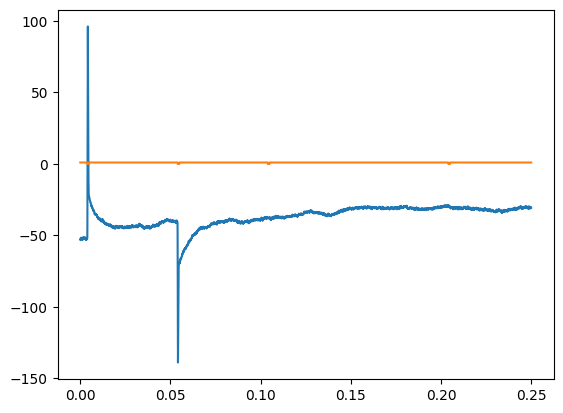

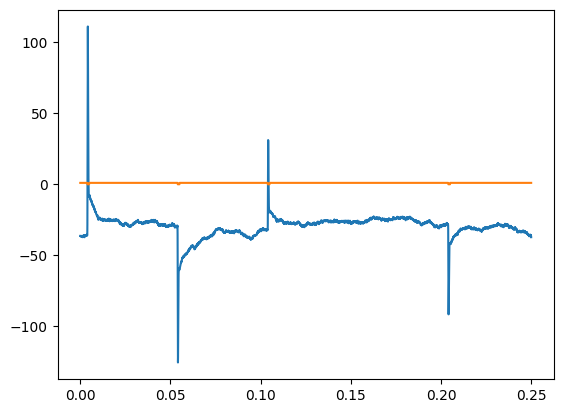

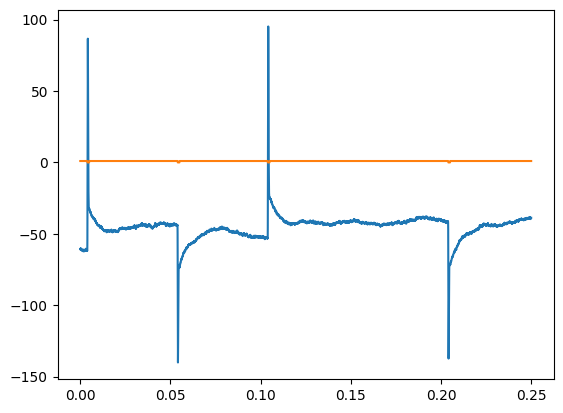

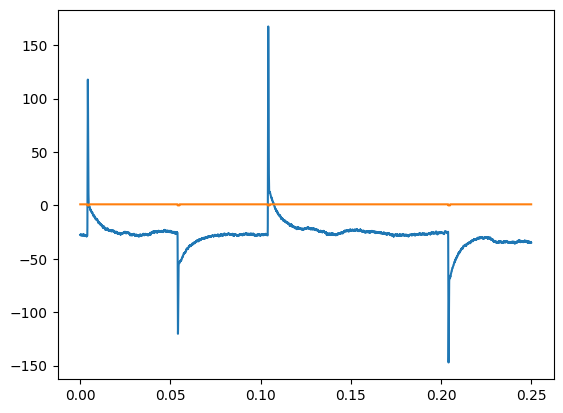

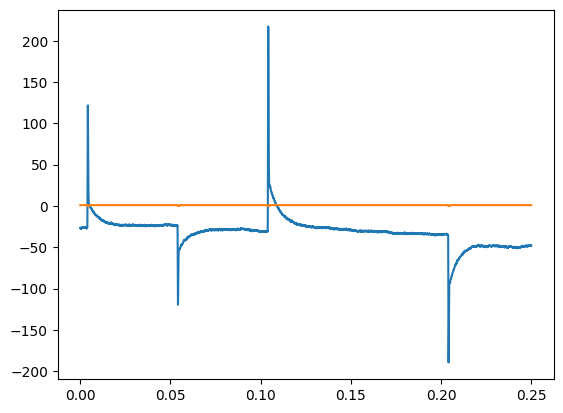

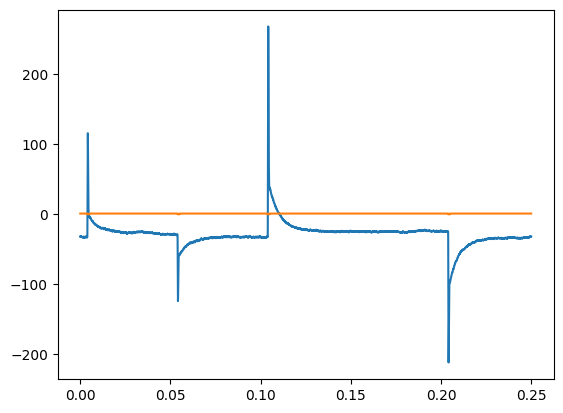

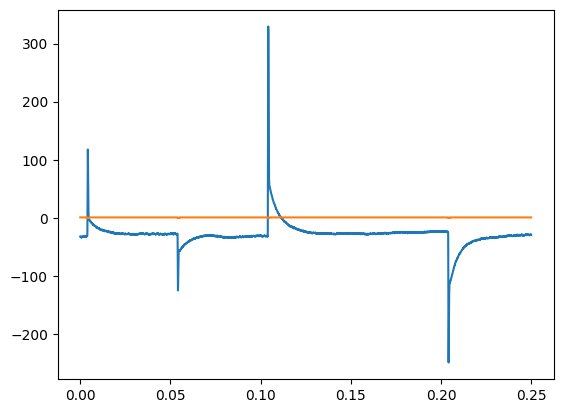

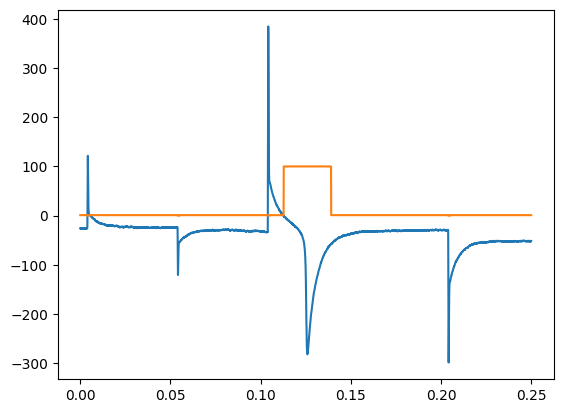

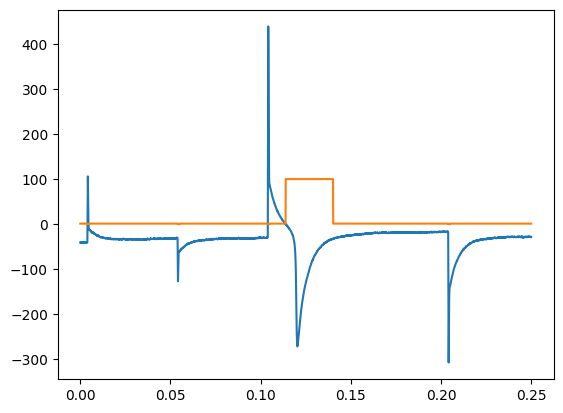

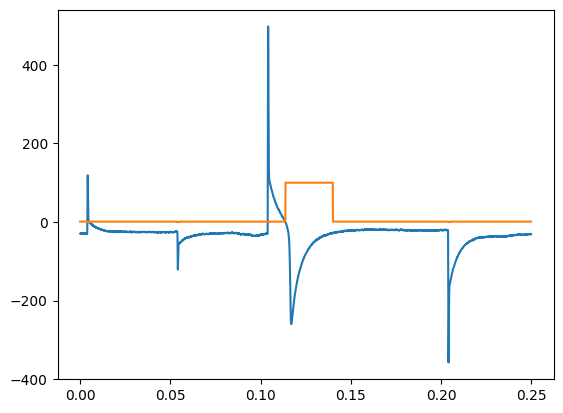

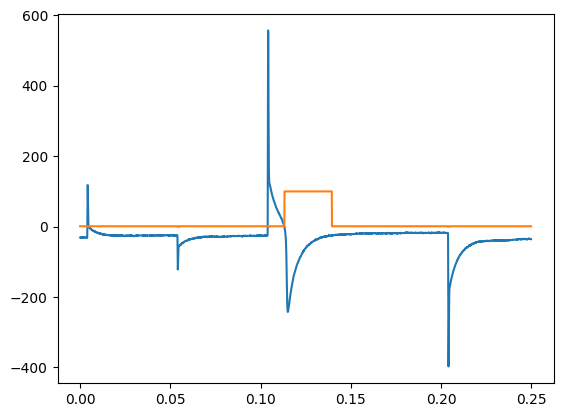

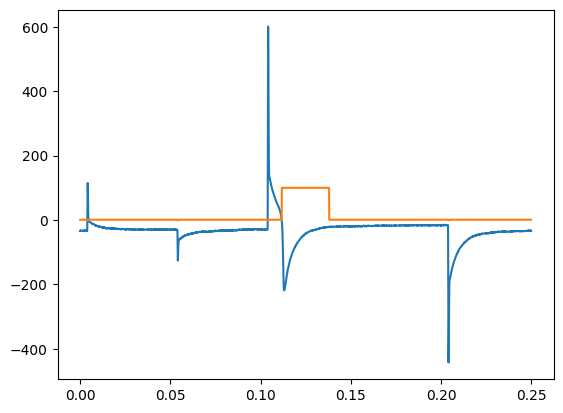

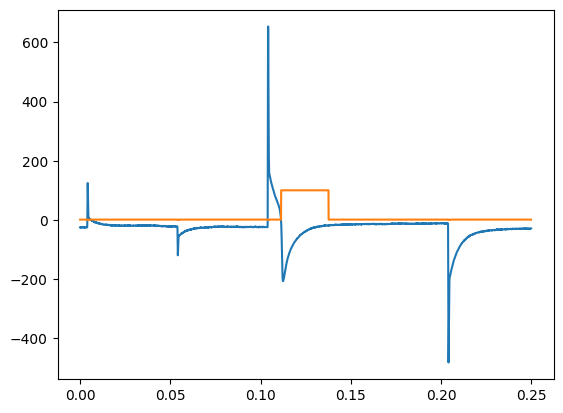

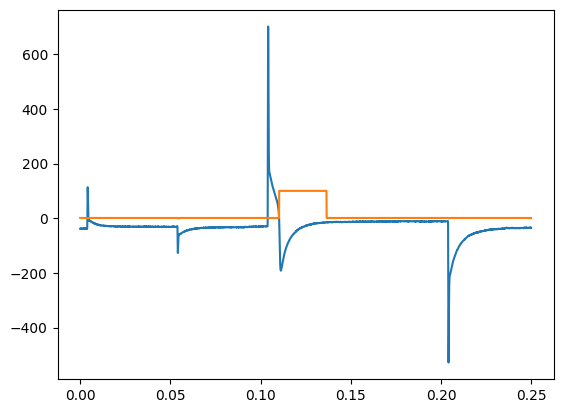

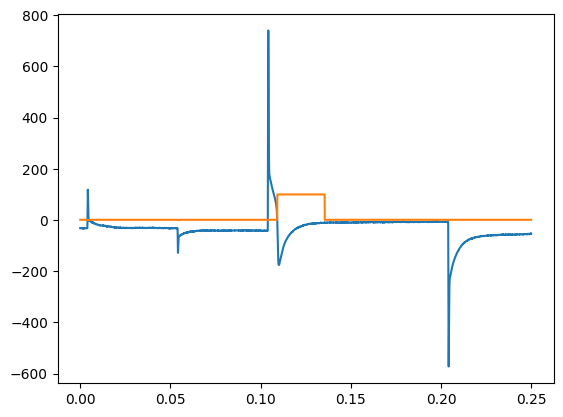

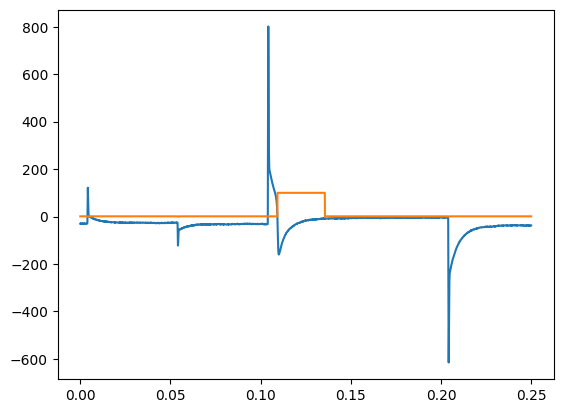

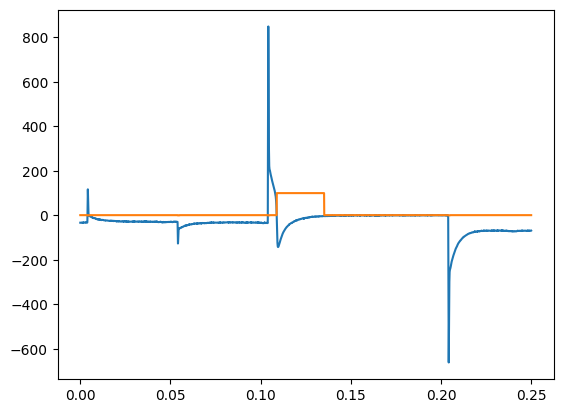

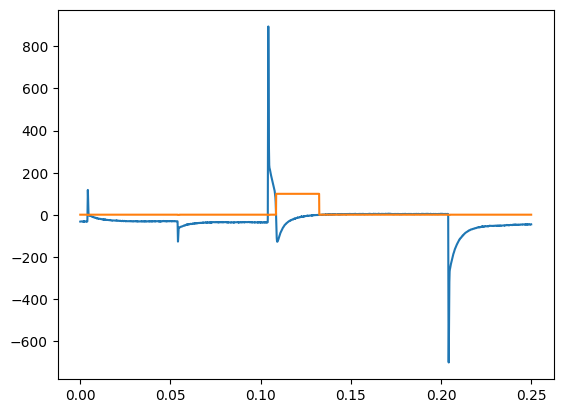

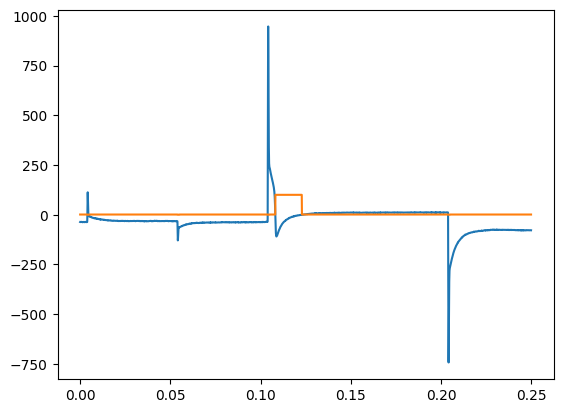

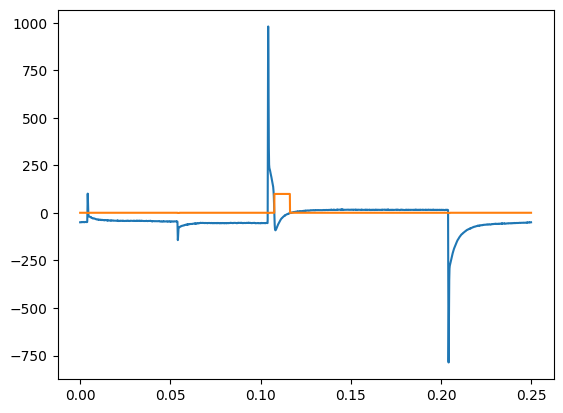

In [11]:
for sweep in weight:
    if sweep =='t':
        continue
    plt.figure()
    plt.plot(trace.t, trace[sweep])
    plt.plot(weight.t, weight[sweep])

In [12]:
# Save weight
weight_name = 'activation.csv'
weights_dir = '../data/weights'

weight = weight.set_index('t')
weight.to_csv(os.path.normpath(os.path.join(weights_dir, weight_name)))